In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import cv2
import torch
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import ParameterGrid

In [2]:
#!pip3 install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [3]:
#!pip install openmim
#!mim install mmdet
#!git clone https://github.com/open-mmlab/mmdetection.git
#%cd mmdetection
#!pip install -q -e .
#!wget https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

In [4]:
#%%bash
#export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/opt/conda/lib/python3.7/site-packages/torch/lib/

In [5]:
df_ens = pd.read_csv('ens.csv')

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


<AxesSubplot:>

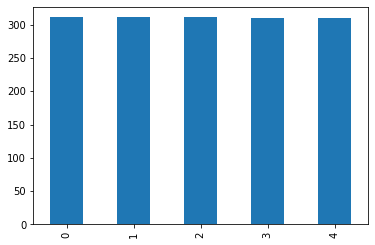

In [6]:
df = pd.read_csv('df_overlap.csv')

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold


N_FOLDS = 5
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=1, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(df.index, df['Pawpularity'])):
    df.iloc[train_index, -1] = i
    
df['fold'] = df['fold'].astype('int')
#train_df_prev = pd.read_csv('train_df_prev.csv')
#df['pred'] = df['path_y'].map(train_df_prev.set_index('path')['norm_score'])

df['pred'] = df['path_x'].map(df_ens.set_index('path')['pred'])


df.fold.value_counts().plot.bar()

In [7]:
COL_DROP = ['hash', 'Name', 'RescuerID', 'Description', 'PetID', 'path_x', 'path_y', 'fold', 'Pawpularity']
COL_FEATURES = [c for c in df.columns if c not in COL_DROP]
#COL_FEATURES = COL_FEATURES[:7]

In [8]:
df[COL_FEATURES]

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,...,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed,pred
0,1,3,307,0,2,1,2,0,2,1,...,1,2,1,1,0,41401,0,3.0,3,0.243858
1,2,1,265,0,2,1,0,0,1,2,...,2,2,1,1,0,41326,0,1.0,1,0.407610
2,1,6,109,307,1,2,0,0,2,2,...,3,3,1,1,0,41326,0,4.0,4,0.325670
3,2,3,247,306,3,2,5,0,1,2,...,1,2,1,3,0,41330,0,3.0,2,0.433446
4,1,24,307,0,1,1,7,0,2,1,...,2,2,2,1,0,41326,0,3.0,4,0.287525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,2,2,254,0,3,4,7,0,2,2,...,2,2,1,4,0,41326,1,10.0,1,0.592540
1549,2,12,266,0,2,6,7,0,1,1,...,1,1,1,1,0,41401,0,6.0,2,0.578181
1550,1,1,307,0,1,2,7,0,2,2,...,3,2,1,1,0,41326,0,4.0,4,0.519718
1551,1,1,307,0,2,2,7,0,1,1,...,2,3,1,1,0,41401,0,4.0,1,0.504252


In [9]:
def train(fold, param):
     
    X_train = df.loc[df['fold'] != fold, COL_FEATURES]
    y_train = df.loc[df['fold'] != fold, 'Pawpularity'].values / 100
    
    X_valid = df.loc[df['fold'] == fold, COL_FEATURES]
    y_valid = df.loc[df['fold'] == fold, 'Pawpularity'].values / 100
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
    
    model = lgb.train(param,
                      train_data,
                      valid_sets=valid_data,
                      early_stopping_rounds=50,
                      verbose_eval=100
                      )
    return model

In [10]:
all_params = {'objective': ['xentropy'],
             'verbosity': [-1],
             'boosting_type': ['gbdt'],
             # 'feature_pre_filter': False,
             # 'bagging_fraction': 1.0,
             'bagging_freq': [1],
             'num_iterations': [10000],
             'early_stopping_round': [10],
             'n_jobs': [16],
             'seed': [114],
             'metric':  ['rmse'],  # trial.suggest_categorical('metric', ['auc', 'binary_logloss', ]), #'auc',
             'learning_rate': [0.01],
              'lambda_l1': [0],
              'lambda_l2': [0],
              'min_child_samples': [50, 100, 200],
              'num_leaves': [3],
              'feature_fraction': [0.8, 1],
              'min_gain_to_split': [0]
             #'lambda_l1': trial.suggest_uniform('lambda_l1', 0, 10),
             #'lambda_l2': trial.suggest_uniform('lambda_l2', 0, 10),
             # 'num_leaves': trial.suggest_int('num_leaves', 7, 127),
             # 'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1),
             # 'min_child_samples': trial.suggest_int('min_child_samples', 5, 500),
             # 'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1),
             # 'feature_fraction_bynode': trial.suggest_uniform('feature_fraction_bynode', 0.5, 1),
             # 'min_gain_to_split': trial.suggest_uniform('min_gain_to_split', 0, 10),
             }

In [11]:
best_score = 1.0e10
best_param = None
for param in tqdm(ParameterGrid(all_params)):
    print(param)
    list_loss = []
    list_imp = []
    for fold in range(5):
        model = train(fold, param)
        sc = model.best_score['valid_0']['rmse'] * 100
        list_loss.append(sc)
        
        imp = pd.DataFrame(model.feature_importance(importance_type='gain'), columns=['imp'])
        imp['col'] = COL_FEATURES
        list_imp.append(imp.set_index('col'))
    sc = np.mean(list_loss)
    if sc < best_score:
        best_score = sc
        best_param = param

  0%|          | 0/6 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


{'bagging_freq': 1, 'boosting_type': 'gbdt', 'early_stopping_round': 10, 'feature_fraction': 0.8, 'lambda_l1': 0, 'lambda_l2': 0, 'learning_rate': 0.01, 'metric': 'rmse', 'min_child_samples': 50, 'min_gain_to_split': 0, 'n_jobs': 16, 'num_iterations': 10000, 'num_leaves': 3, 'objective': 'xentropy', 'seed': 114, 'verbosity': -1}
Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 0.183801
[200]	valid_0's rmse: 0.179309
[300]	valid_0's rmse: 0.177889
[400]	valid_0's rmse: 0.177576
Early stopping, best iteration is:
[395]	valid_0's rmse: 0.177548
Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 0.191165
[200]	valid_0's rmse: 0.185704
[300]	valid_0's rmse: 0.183861
[400]	valid_0's rmse: 0.182919
Early stopping, best iteration is:
[467]	valid_0's rmse: 0.182666
Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 0.189441
[200]	valid_0's rmse: 0.183579
[300]	valid_0's rmse: 0.181543
[400]	valid_0

In [12]:
print(best_param)
print(best_score)

{'bagging_freq': 1, 'boosting_type': 'gbdt', 'early_stopping_round': 10, 'feature_fraction': 1, 'lambda_l1': 0, 'lambda_l2': 0, 'learning_rate': 0.01, 'metric': 'rmse', 'min_child_samples': 100, 'min_gain_to_split': 0, 'n_jobs': 16, 'num_iterations': 10000, 'num_leaves': 3, 'objective': 'xentropy', 'seed': 114, 'verbosity': -1}
17.81004895148758


In [13]:
with open('models/model_lgb_1215.pkl', 'wb') as f:
    pickle.dump(model, f, -1)

In [14]:
#imp = pd.DataFrame(model.feature_importance(importance_type='gain'), columns=['imp'])
#imp['col'] = COL_FEATURES
imp = sum(list_imp) / 5
imp.sort_values('imp', ascending=False)

,imp
col,
pred,2484.822111
Breed1,413.377236
PhotoAmt,49.470138
Age,47.173660
Breed2,30.180799
State,20.402405
Vaccinated,11.354293
Quantity,10.370057
AdoptionSpeed,8.409437


In [15]:
np.sqrt(((df.Pawpularity / 100 - df.pred)**2).mean())

0.18342260907630953

In [16]:
import os
train_df_prev = pd.read_csv('../input/petfinder-adoption-prediction/train/train.csv')
print(train_df_prev.shape)
train_df_prev['path'] = '../input/petfinder-adoption-prediction/train_images/' + train_df_prev['PetID'] + '-1.jpg'
#train_df_prev = train_df_prev[['path', 'AdoptionSpeed']]
train_df_prev = train_df_prev[train_df_prev['path'].map(os.path.exists)]
print(train_df_prev.shape)

(14993, 24)
(14652, 25)


In [17]:
train_df_prev['pred'] = train_df_prev['path'].map(pd.read_csv('train_df_prev.csv', index_col='path')['norm_score'])
train_df_prev['norm_score'] = model.predict(train_df_prev[model.feature_name()])
train_df_prev

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,path,pred,norm_score
0,2,Nibble,3,299,0,1,1,7,0,1,...,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,../input/petfinder-adoption-prediction/train_i...,0.280212,0.291242
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,../input/petfinder-adoption-prediction/train_i...,0.283639,0.312819
2,1,Brisco,1,307,0,1,2,7,0,2,...,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,../input/petfinder-adoption-prediction/train_i...,0.523466,0.518526
3,1,Miko,4,307,0,2,1,2,0,2,...,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,../input/petfinder-adoption-prediction/train_i...,0.380708,0.348730
4,1,Hunter,1,307,0,1,1,0,0,2,...,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,../input/petfinder-adoption-prediction/train_i...,0.573102,0.517711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,NaN,2,266,0,3,1,0,0,2,...,41326,61c84bd7bcb6fb31d2d480b1bcf9682e,0,I have 4 kittens that need to be adopt urgentl...,dc0935a84,3.0,2,../input/petfinder-adoption-prediction/train_i...,0.388900,0.426947
14989,2,Serato & Eddie,60,265,264,3,1,4,7,2,...,41326,1d5096c4a5e159a3b750c5cfcf6ceabf,0,Serato(female cat- 3 color) is 4 years old and...,a01ab5b30,3.0,4,../input/petfinder-adoption-prediction/train_i...,0.299093,0.307952
14990,2,Monkies,2,265,266,3,5,6,7,3,...,41326,6f40a7acfad5cc0bb3e44591ea446c05,0,"Mix breed, good temperament kittens. Love huma...",d981b6395,5.0,3,../input/petfinder-adoption-prediction/train_i...,0.514437,0.563169
14991,2,Ms Daym,9,266,0,2,4,7,0,1,...,41336,c311c0c569245baa147d91fa4e351ae4,0,she is very shy..adventures and independent..s...,e4da1c9e4,3.0,4,../input/petfinder-adoption-prediction/train_i...,0.262555,0.296012


<AxesSubplot:>

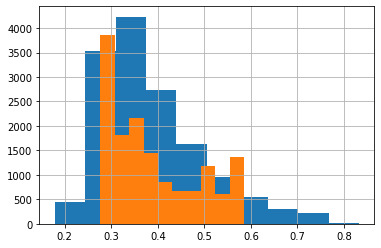

In [18]:
train_df_prev.pred.hist()
train_df_prev.norm_score.hist()

In [19]:
train_df_prev[['path', 'norm_score']].to_csv('train_df_prev2.csv', index=False)